In [2]:
import torch

model_name = 'meta-llama/Llama-2-7b-chat-hf'
# model_name = 'meta-llama/Llama-3.1-8B-Instruct'
# model_name = 'Qwen/Qwen3-4B'
# model_name = 'Qwen/Qwen3-1.7B'
clean = model_name.replace("/", "_").replace(":", "_").replace("@", "_")
chat = f'/mnt/SSD7/kartik/reasoning/residuals/{clean}/chat_completion_residuals.pt'
gen = f'/mnt/SSD7/kartik/reasoning/residuals/{clean}/completion_residuals.pt'
resid_chat = torch.load(chat)
resid_gen = torch.load(gen)

In [3]:
chat_pre = []
gen_pre = []
for i in range(len(resid_chat['pre'])):
    chat_pre_i = resid_chat['pre'][i][:, -1]
    chat_pre.append(chat_pre_i)

    gen_pre_i = resid_gen['pre'][i][:, -1]
    gen_pre.append(gen_pre_i)

chat_pre = torch.stack(chat_pre)
gen_pre = torch.stack(gen_pre)

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print(f"Shape of chat_pre: {chat_pre.shape}")
print(f"Shape of gen_pre: {gen_pre.shape}")

# Combine both sets of trajectories into a single tensor for PCA
# Shape will be (200, 32, 4096)
all_trajectories_tensor = torch.cat([chat_pre, gen_pre], dim=0)

num_trajectories, num_layers, hidden_dim = all_trajectories_tensor.shape
reshaped_for_pca = all_trajectories_tensor.reshape(-1, hidden_dim)

reshaped_for_pca_np = reshaped_for_pca

print("\nFitting PCA on all 6400 trajectory points...")
pca = PCA(n_components=2)
projected_trajectories = pca.fit_transform(reshaped_for_pca_np)

projected_trajectories = projected_trajectories.reshape(num_trajectories, num_layers, -1)
print("PCA fitting complete.")

Shape of chat_pre: torch.Size([100, 32, 4096])
Shape of gen_pre: torch.Size([100, 32, 4096])

Fitting PCA on all 6400 trajectory points...
PCA fitting complete.


In [7]:
comp = resid_gen['pre'][1][:, 42]
ref = resid_gen['pre'][1][:, 41]

vec = comp - ref
print(vec.shape)
new = pca.transform(vec)

comp_pca = pca.transform(comp)
ref_pca = pca.transform(ref)

torch.Size([32, 4096])


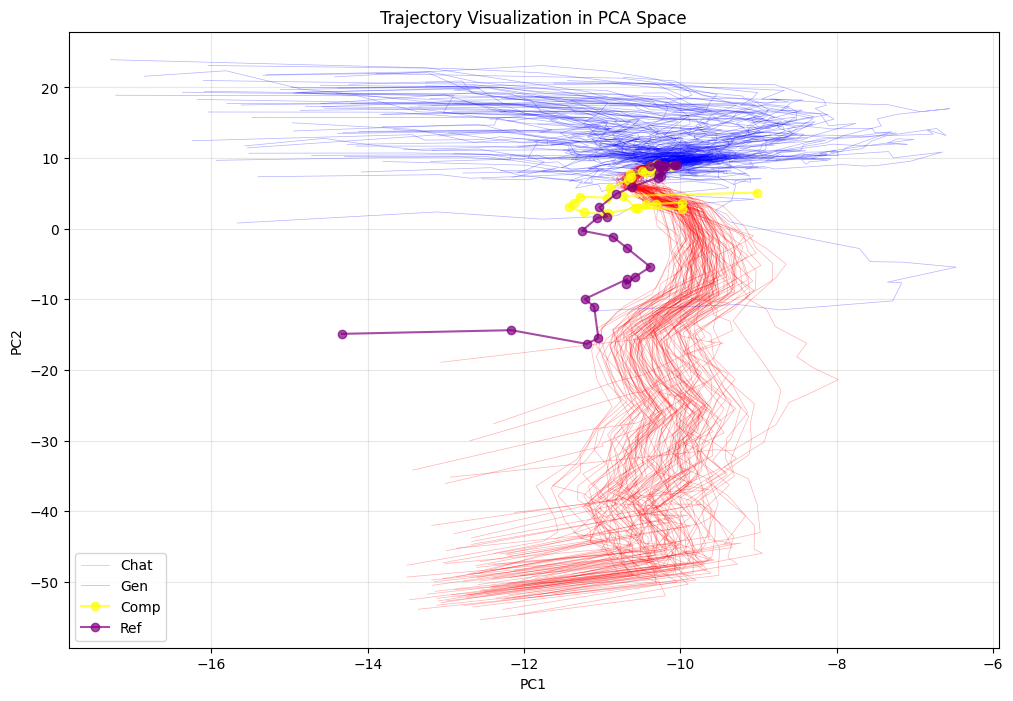

In [8]:
# Plot the trajectories
plt.figure(figsize=(12, 8))

# Split the projected trajectories back into chat and gen
chat_projected = projected_trajectories[:100]  # First 100 are chat
gen_projected = projected_trajectories[100:]   # Next 100 are gen

# Plot chat trajectories
for i in range(len(chat_projected)):
    label = 'Chat' if i == 0 else None
    plt.plot(chat_projected[i, :, 0], chat_projected[i, :, 1], 'r-', alpha=0.3, linewidth=0.5, label=label)

# Plot gen trajectories  
gen_label_added = False
for i in range(len(gen_projected)):
    if i == 50:
        continue
    label = 'Gen' if not gen_label_added else None
    if not gen_label_added:
        gen_label_added = True
    plt.plot(gen_projected[i, :, 0], gen_projected[i, :, 1], 'b-', alpha=0.3, linewidth=0.5, label=label)


# plt.plot(new[:, 0], new[:, 1], 'go-', alpha=0.3, linewidth=1.5, label='diff')
plt.plot(comp_pca[:, 0], comp_pca[:, 1], 'o-', color='yellow', alpha=0.7, linewidth=1.5, label='Comp')
plt.plot(ref_pca[:, 0], ref_pca[:, 1], 'o-', color='purple', alpha=0.7, linewidth=1.5, label='Ref')
# plt.plot(vec_pca[:, 0], vec_pca[:, 1], color='black', alpha=0.7, linewidth=1.5, label='Vec')


plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Trajectory Visualization in PCA Space')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()